In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Retail/supermarket_sales.csv")


In [3]:
df['Datetime'] =(df['Date'] + ' ' + df['Time'])
df["Date"] = pd.to_datetime(df["Date"])
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m/%d/%Y %H:%M')
df.info()
print("-"*58)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Invoice ID               1000 non-null   object        
 1   Branch                   1000 non-null   object        
 2   City                     1000 non-null   object        
 3   Customer type            1000 non-null   object        
 4   Gender                   1000 non-null   object        
 5   Product line             1000 non-null   object        
 6   Unit price               1000 non-null   float64       
 7   Quantity                 1000 non-null   int64         
 8   Tax 5%                   1000 non-null   float64       
 9   Total                    1000 non-null   float64       
 10  Date                     1000 non-null   datetime64[ns]
 11  Time                     1000 non-null   object        
 12  Payment                  1000 non-n

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


In [4]:
dfsale = df[['Branch','Date','Total']]
dfsale = dfsale.set_index("Date")
BranchA = dfsale[dfsale["Branch"] == "A"].drop(["Branch"],axis = 1).sort_values(by='Date')
BranchB = dfsale[dfsale["Branch"] == "B"].drop(["Branch"],axis = 1).sort_values(by='Date')
BranchC = dfsale[dfsale["Branch"] == "C"].drop(["Branch"],axis = 1).sort_values(by='Date')


In [5]:
BranchA = BranchA.groupby(["Date"]).sum()
BranchB = BranchB.groupby(["Date"]).sum()
BranchC = BranchC.groupby(["Date"]).sum()

In [6]:
idx = pd.date_range('2019-01-01', '2019-03-30')
BranchA = BranchA.reindex(idx, fill_value=0)
BranchB = BranchB.reindex(idx, fill_value=0)
BranchC = BranchC.reindex(idx, fill_value=0)

In [7]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(12, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

<ipython-input-7-6addf69a9922>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Total = -1.54 * t + 0.00
Total decrease in next quater   Total    11.063853
dtype: float64


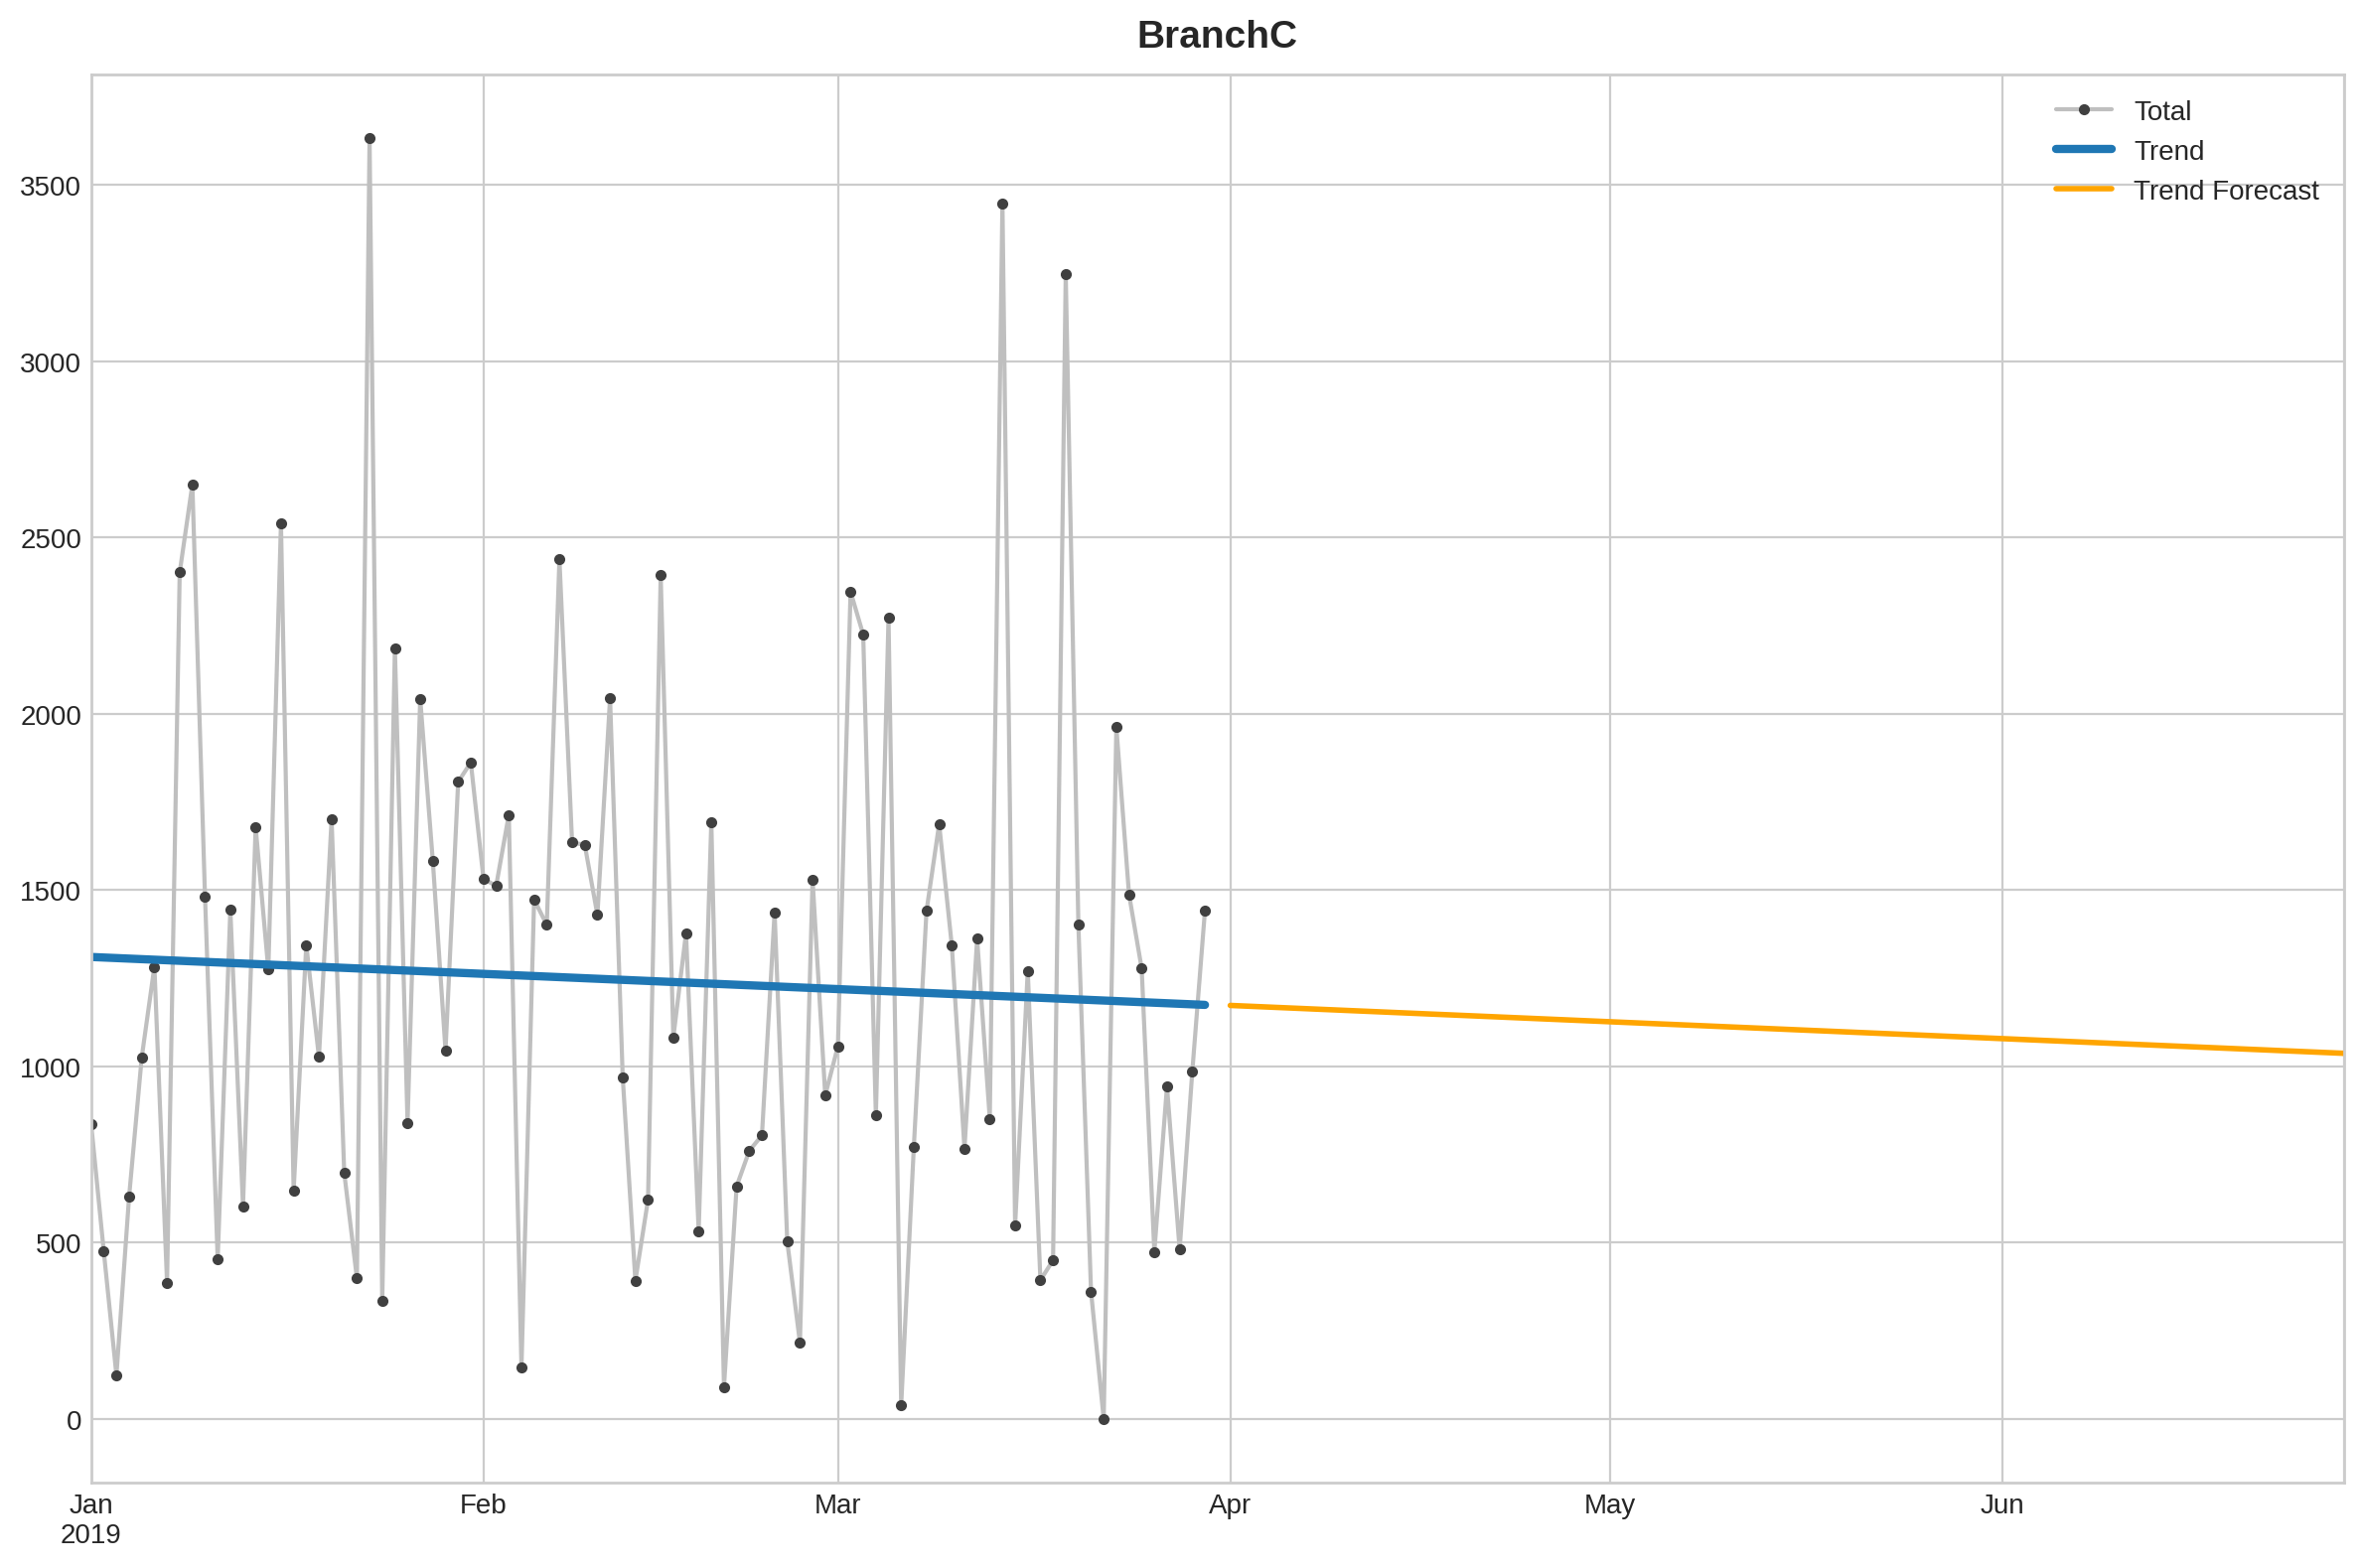

In [8]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=BranchC.index, constant=True, order=1, drop=False)
X = dp.in_sample()

X.head()

y = BranchC['Total']
model =  LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

X = dp.out_of_sample(steps=89)
y_fore = pd.Series(model.predict(X), index=pd.date_range(start='2019-04-01', end='2019-06-28'))
y_fore.head()

ax = BranchC.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=2, label="Trend Forecast", color='orange')
plt.title("BranchC")
ax.legend()

print(f'Total = {model.coef_[1]:.2f} * t + {model.intercept_:.2f}')
print('Total decrease in next quater   '+str((BranchC.sum()-y_fore.sum())/BranchC.sum()*100) )